# External source 3 prediction

While investigating and predicting the credit default outcome, we saw that one of the best predictors was external source variables, especially external source 3. The column description file of the dataset describes this variable as *normalized score from external data source*. Seems that this information is extracted from somewhere else. As it is one of the best identifiers of default loans, we will try to see if this value can be approximated using other data sources available at the time of application. This way, we would not need to refer to the external source and have all resources in-house. In this notebook, we will explore this possibility.

# Setup

In [7]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, \
                            mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import (GradientBoostingRegressor,
                              RandomForestRegressor)

import pickle as pkl
import joblib
from feature_engine.selection import (DropConstantFeatures,
                                      DropCorrelatedFeatures)

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold , cross_validate, cross_val_score

from helpers import helpers as h

set_config(transform_output = "pandas")

## Load and prepare data

We will start with uploading the data with engineered features and preparing it for modelling.

In [2]:
train_features = pd.read_pickle("./home_credit_features.pkl") 

with open("home_credit_feature_lists.pkl", "rb") as f:
    categorical_features, numeric_features = pkl.load(f)

First, we will exclude those data rows where external data source 3 had missing values.

In [3]:
train_features = train_features[train_features['ext_source_3'].notna()]

We will exclude all the features which were created using the external source variable 3 to prevent data leakage problems. Other external source variables will be excluded as well since we do not know if they were derived using the external source model or not.

In [4]:
numeric_exclude = ['ext_source_1', 
                   'ext_source_2', 'ext_source_cols_mean', 
                    'ext_source_cols_max', 
                    'ext_source_cols_min', 
                    'ext_source_cols_sum',
                    'ext_source_cols_multi', 
                    'ext_source_cols_var',
                  'target']

train_features.drop(numeric_exclude, axis=1,
                    inplace=True)

numeric_features = [col for col in  numeric_features 
                       if col not in {'ext_source_1', 
                   'ext_source_2', 'ext_source_cols_mean', 
                    'ext_source_cols_max', 
                    'ext_source_cols_min', 
                    'ext_source_cols_sum',
                    'ext_source_cols_multi', 
                    'ext_source_cols_var',
                  'target'}]

Data will be divided into training, test and validation datasets.

In [5]:
y = train_features.ext_source_3
X = train_features.drop(['sk_id_curr', 'ext_source_3'], axis=1)

numeric_features = [col for col in  numeric_features 
                       if col not in {'ext_source_3'}]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

subset_size = 0.15

X_train_subset = X_train.copy()
y_train_subset = y_train.copy()

X_train_subset = X_train_subset.iloc[:round(X_train_subset.shape[0] * subset_size), :]
y_train_subset = y_train_subset.iloc[:round(y_train_subset.shape[0] * subset_size)]

In [9]:
preprocess_transformer = h.make_preprocessing_pipeline(X_train,
                                                       numeric_features, 
                                                       categorical_features)

steps = [
    ('preprocess', preprocess_transformer),
    ('constant', DropConstantFeatures(tol=0.99)),
    ('correlated', DropCorrelatedFeatures(variables=None, 
                                          method='pearson', 
                                          threshold=0.9))
    ]

preprocess_features = Pipeline(steps)

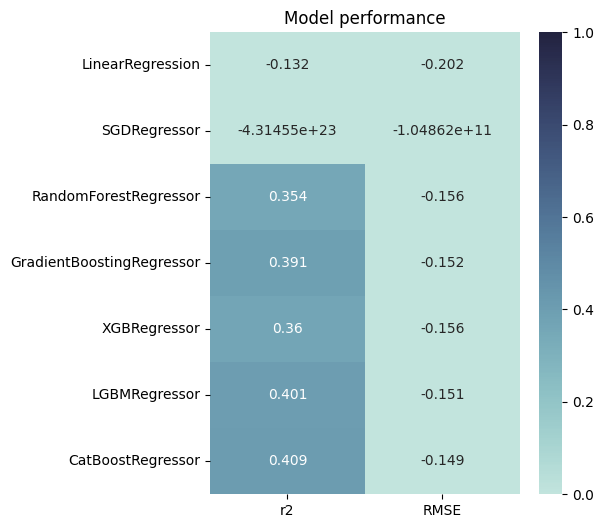

In [7]:
regressors = [
    LinearRegression(),
    SGDRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    XGBRegressor(objective ='reg:squarederror'),
    LGBMRegressor(),
    CatBoostRegressor(verbose=0),
]

score_models = h.fit_evaluate_regressors(preprocess_features, 
                                        regressors,
                                        X_train_subset, y_train_subset)

label_reg = [
    'LinearRegression',
    'SGDRegressor',
    'RandomForestRegressor',
    'GradientBoostingRegressor',
    'XGBRegressor',
    'LGBMRegressor',
    'CatBoostRegressor']

h.plot_performance(score_models, label_reg)
plt.title('Model performance');

The best performing model is Catboost Regressor. We will continue with this model.

### Feature selection

The best performing model will be re-trained using a full dataset. Afterwards, the 70 most important features will be selected for further model optimization

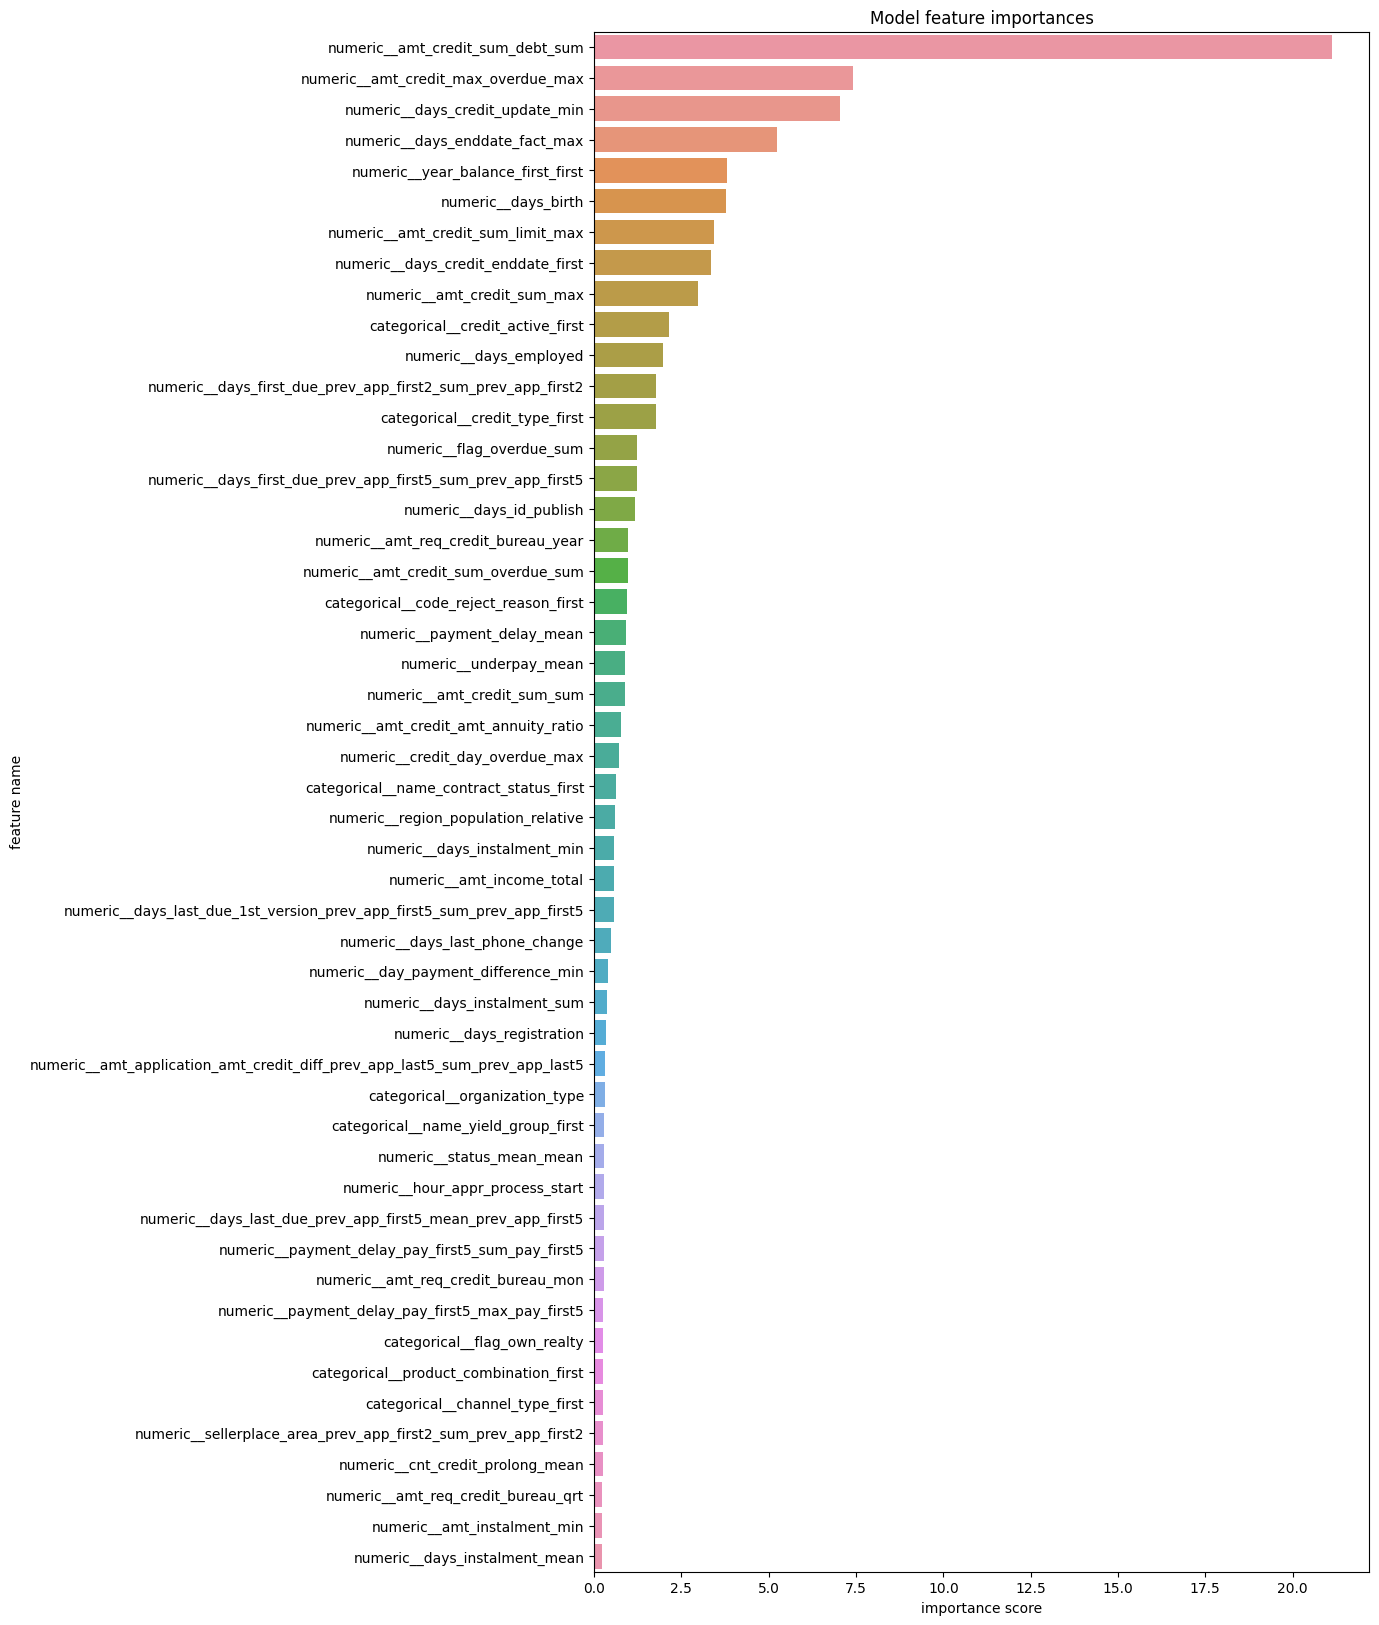

In [10]:
X_train_selected = preprocess_features.fit_transform(X_train)
X_test_selected = preprocess_features.transform(X_test)

catboost_reg = CatBoostRegressor(verbose=0)
catboost_reg.fit(X_train_selected, y_train)

col_names_catboost = h.plot_importance(catboost_reg,
                                       X_train_selected.columns, 50)

### Hyperparameter tuning

Next, we will tune the hyperparameters of the model using a subset of training data.

In [11]:
X_train_selected_catboost = X_train_selected[col_names_catboost.tolist()]
X_test_selected_catboost = X_test_selected[col_names_catboost.tolist()]

subset_size = 0.15

X_train_selected_catboost_subset = X_train_selected_catboost \
                                  .iloc[:round(X_train_selected_catboost \
                                  .shape[0] * subset_size), :]

y_train_subset = y_train.iloc[:round(y_train.shape[0] * subset_size)]

n_trials = 25
catboost_best_params = h.run_optuna_study(X_train_selected_catboost_subset,
                                         y_train_subset, 
                                         h.objective_catboost_regression,
                                         "maximize", "neg_root_mean_squared_error", 
                                         n_trials=n_trials)

[I 2023-01-26 18:57:32,165] A new study created in memory with name: no-name-2e71376b-6869-4c7e-ae76-8843adda0d71
[I 2023-01-26 18:58:26,689] Trial 0 finished with value: -0.17505402142057233 and parameters: {'learning_rate': 0.00020318673460438576, 'depth': 1, 'l2_leaf_reg': 1.201791680915963, 'min_child_samples': 8, 'bootstrap_type': 'MVS'}. Best is trial 0 with value: -0.17505402142057233.
[I 2023-01-26 19:12:24,413] Trial 1 finished with value: -0.15220152732488396 and parameters: {'learning_rate': 0.0005518561295684676, 'depth': 7, 'l2_leaf_reg': 2.6705966202070384, 'min_child_samples': 4, 'bootstrap_type': 'Bernoulli'}. Best is trial 1 with value: -0.15220152732488396.
[I 2023-01-26 19:37:33,685] Trial 2 finished with value: -0.15360017451612218 and parameters: {'learning_rate': 0.10748621519320974, 'depth': 9, 'l2_leaf_reg': 5.345963030152373, 'min_child_samples': 16, 'bootstrap_type': 'Bayesian'}. Best is trial 1 with value: -0.15220152732488396.
[I 2023-01-26 19:44:59,782] Tri

## Model evaluation and deployment

The model will be retrained using a full training set using the optimized parameters and tested using a testing dataset.

In [16]:
catboost_best_params['verbose'] = 0

catboost_reg = CatBoostRegressor(**catboost_best_params)
catboost_reg.fit(X_train_selected_catboost, y_train)

y_test_predicted = catboost_reg.predict(X_test_selected_catboost)

print(f'R2 score: {r2_score(y_test, y_test_predicted):.3f}')
print(f'RMSE: {mean_squared_error(y_test, y_test_predicted, squared=False):.3f}')

R2 score: 0.331
RMSE: 0.159


The RMSE value is 0.16. Given the fact that the values of external source 3 range between 0-1, this is still a relatively large mistake. Therefore, the model usability should be evaluated further, by taking into account the current price of external sourcing and the potential harm of incorrect predictions of the variable. Presumably, the model should be improved to be useful.

Saving the model pipeline and features.

In [21]:
joblib.dump(preprocess_features, 'preprocess_features_ext_source.pkl')

['preprocess_features_ext_source.pkl']

In [22]:
joblib.dump(catboost_reg, 'ext_source_3_model.pkl')

['ext_source_3_model.pkl']

## Model deployment

Model was deployed on google cloud using App Engine with streamlit: [external source variable prediction](https://loan-prediction-371514.nn.r.appspot.com)

## Conclusions

* Here, we used engineered features to predict external source 3 intending to derive this source from available data without referring to external resources.
* Features were selected and hyperparameter optimizations were performed on the best performing model CatBoost Regressor.
* Performance on the testing dataset returned **R2 score: 0.331** and **RMSE: 0.159**.
* The model performance gives a relatively high error and perhaps should be improved to become useful.